In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
%reset
import matplotlib
import numpy as np
import scipy as sp
import netCDF4 as nc
import cmocean as cm
from scipy.io import loadmat
import xarray as xr
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs

%matplotlib inline

from salishsea_tools import visualisations as vis
from sys import platform

### Plot the 2018 freshet, as it's the freshet in the past 4 years 

In [3]:
if platform == 'darwin':
    path_to_file = '/Users/rmueller/Data/SalishSeaCast/nowcast-green.201905/'
    fname = 'SalishSea_1h_20180520_20180520_grid_T.nc'
    bathy = nc.Dataset('/Users/rmueller/Data/SalishSeaCast/grid/bathymetry_201702.nc')
    mesh = nc.Dataset('/Users/rmueller/Data/SalishSeaCast/grid/mesh_mask201702.nc')
    rivers_in = '/Users/rmueller/Data/Pawlowicz_rivers/PNWrivers.mat'
    thalweg_in = '/Users/rmueller/Projects/MEOPAR/tools/bathymetry/thalweg_working.txt'
else:
    path_to_file = '/results2/SalishSea/nowcast-green.201905/20may18/'
    fname = 'SalishSea_1h_20180520_20180520_grid_T.nc'
    bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
    mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
    rivers_in ='fill_in' #********
    thalweg_in = 'fill_in' #********

In [14]:
variable_to_plot = 'vosaline'
hour_of_day_to_plot = 12
x_size_of_plot = 11
y_size_of_plot = 4
vmin = 26
vmax = 34
stepsize = 0.2
do_I_want_to_save_fig = True
figstr = '2018may20_thalweg.png'
tit = '2018 Freshet'
cbar_label = 'Salinity'
titlefontsize = 20
cbarfontsize = 18
cbartickfontsize = 18
axistickfontsize = 18
#colourmap I've chosen, from https://matplotlib.org/cmocean/
t_cmap = cm.cm.dense

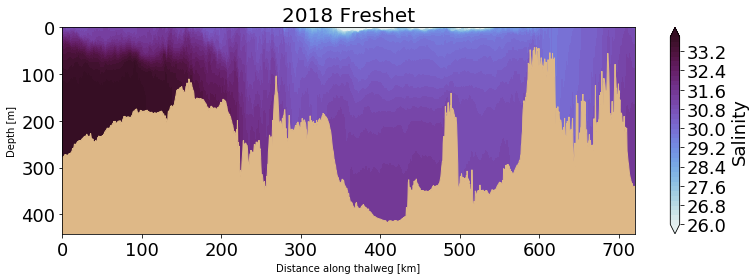

In [15]:
#bathymetry and meshmap
nc_to_plot = nc.Dataset(path_to_file + fname)
data_to_plot = nc_to_plot[variable_to_plot][hour_of_day_to_plot-1,:,:,:]


fig, ax1 = plt.subplots(1,1,figsize=(x_size_of_plot,y_size_of_plot))
cbar = vis.contour_thalweg(ax1, data_to_plot, bathy, mesh, np.arange(vmin, vmax, stepsize), cmap = t_cmap, thalweg_file=thalweg_in)
ax1.set_title(tit , fontsize = titlefontsize)
cbar.set_label(cbar_label, fontsize = cbarfontsize)
cbar.ax.tick_params(labelsize=cbartickfontsize) 
ax1.tick_params(axis='both', which='major', labelsize=axistickfontsize)


fig.tight_layout()
plt.show()
if do_I_want_to_save_fig == True:
    fig.savefig(figstr)


In [10]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')

def plot_map(ax, cst, bounds, grid, w_map = [-129, -121, 47, 51.2], idepth=0):
    """Plot Strait of Georgia study area on Basemap object
    """
    
    # Plot Basemap
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    dat = grid['Bathymetry'][:]
    C = ax.contourf(x, y, dat, levels=np.arange(0, 500, 10), cmap=cm.cm.deep, extend = 'both') # extend='both', zorder=.2)


    #Colorbar
    fig.subplots_adjust(bottom=0.0)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Depth [m]')
    cbar.set_label(label='Depth [m]', size=14)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    

    # Plot Thalweg
    plot_thalweg(ax, x, y)

NameError: name 'Basemap' is not defined

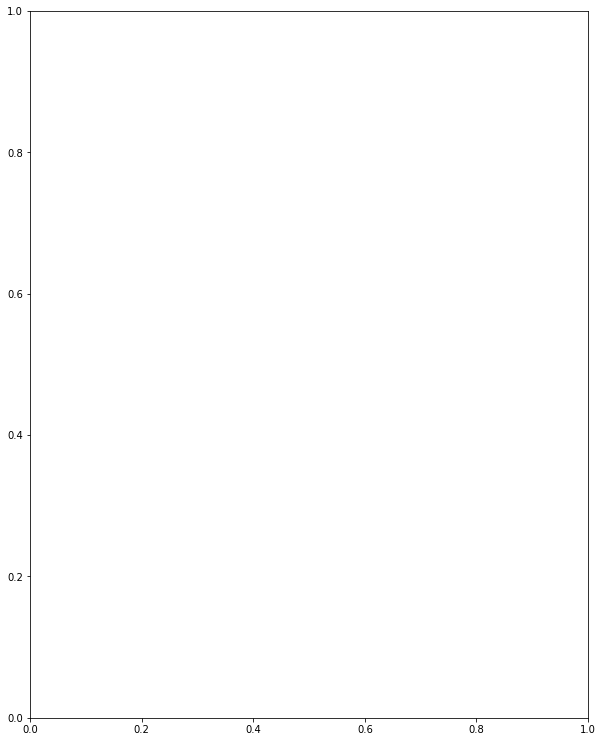

In [7]:
# Load NEMO grid
grid_NEMO = bathy #xr.open_dataset(bathy, mask_and_scale=False)

# Load Fraser coastline
PNWrivers = loadmat(rivers_in)

# Define Fraser coastline regions
bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# Plot Model Domain
plot_map(ax, PNWrivers, bounds, grid_NEMO, w_map = [-127, -121, 47, 51.2], idepth=0)